In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='fruits.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('fruits.zip')
f.keys()
!unzip fruits.zip

Archive:  fruits.zip
  inflating: fruits/test/apple/Image_1.jpg  
  inflating: fruits/test/apple/Image_10.jpg  
  inflating: fruits/test/apple/Image_2.jpg  
  inflating: fruits/test/apple/Image_3.jpg  
  inflating: fruits/test/apple/Image_4.jpg  
  inflating: fruits/test/apple/Image_5.jpg  
  inflating: fruits/test/apple/Image_6.JPG  
  inflating: fruits/test/apple/Image_7.jpg  
  inflating: fruits/test/apple/Image_8.jpg  
  inflating: fruits/test/apple/Image_9.jpg  
  inflating: fruits/test/banana/Image_1.jpg  
  inflating: fruits/test/banana/Image_10.jpg  
  inflating: fruits/test/banana/Image_2.jpg  
  inflating: fruits/test/banana/Image_3.jpg  
  inflating: fruits/test/banana/Image_4.jpg  
  inflating: fruits/test/banana/Image_5.jpg  
  inflating: fruits/test/banana/Image_6.jpg  
  inflating: fruits/test/banana/Image_8.jpg  
  inflating: fruits/test/banana/Image_9.jpg  
  inflating: fruits/test/kiwi/Image_1.jpg  
  inflating: fruits/test/kiwi/Image_10.jpg  
  inflating: fruits/test

In [3]:
train_dir = '/content/fruits/train'
validation_dir = '/content/fruits/validation'
test_dir = '/content/fruits/test'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
no_classes = 5

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 384 files belonging to 5 classes.
Found 48 files belonging to 5 classes.
Found 49 files belonging to 5 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)
class_names = validation_dataset.class_names
print(class_names)
class_names = test_dataset.class_names
print(class_names)

['apple', 'banana', 'kiwi', 'orange', 'watermelon']
['apple', 'banana', 'kiwi', 'orange', 'watermelon']
['apple', 'banana', 'kiwi', 'orange', 'watermelon']


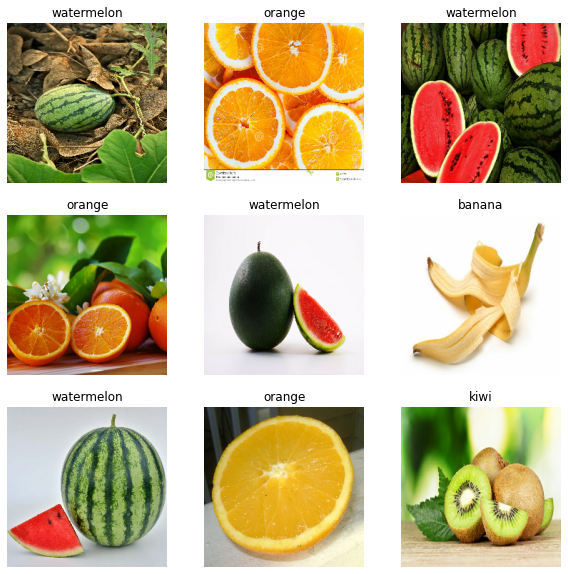

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(224, 224, 3))
x = layers.RandomContrast(0.2)(inputs)
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(no_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0     

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
)

Epoch 1/25


12/12 [==============================] - 48s 3s/step - loss: 635.9510 - accuracy: 0.2812 - val_loss: 16.8363 - val_accuracy: 0.4375
Epoch 2/25
12/12 [==============================] - 49s 3s/step - loss: 5.4422 - accuracy: 0.4141 - val_loss: 1.3389 - val_accuracy: 0.7083
Epoch 3/25
12/12 [==============================] - 43s 3s/step - loss: 1.1072 - accuracy: 0.6224 - val_loss: 1.2732 - val_accuracy: 0.8125
Epoch 4/25
12/12 [==============================] - 44s 3s/step - loss: 0.7836 - accuracy: 0.7500 - val_loss: 0.8169 - val_accuracy: 0.8750
Epoch 5/25
12/12 [==============================] - 44s 3s/step - loss: 0.3267 - accuracy: 0.9036 - val_loss: 0.6594 - val_accuracy: 0.9167
Epoch 6/25
12/12 [==============================] - 43s 3s/step - loss: 0.1632 - accuracy: 0.9453 - val_loss: 0.7521 - val_accuracy: 0.9583
Epoch 7/25
12/12 [==============================] - 51s 4s/step - loss: 0.0721 - accuracy: 0.9792 - val_loss: 0.6734 - val_accuracy: 0.9792
Epoch 8/25
12/12 [==========

In [9]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

2/2 [==============================] - 2s 338ms/step - loss: 1.0151 - accuracy: 0.9388
Test loss: 1.0150773525238037
Test accuracy: 0.9387755393981934


In [17]:
import IPython.display as display
from PIL import Image
import io
from google.colab import files

# Prompt the user to upload an image file
uploaded_file = files.upload()

# Load the image using Pillow
img = Image.open(io.BytesIO(uploaded_file[next(iter(uploaded_file))]))

# Save the image to the content folder
img.save('uploaded_image.jpg')

# Load the image from the content folder
img = keras.preprocessing.image.load_img(
    'uploaded_image.jpg', target_size=(224, 224)
)

# Convert the image to a numpy array
img_array = keras.preprocessing.image.img_to_array(img)

# Expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = keras.applications.resnet50.preprocess_input(img_array)

# Make a prediction using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print("The predicted class is:", predicted_class_name)


Saving Image_6.jpg to Image_6.jpg
1/1 [==============================] - 0s 42ms/step
The predicted class is: banana
